# Image Based Point Cloud Segmentation

Kefeng Huang timkhuang@icloud.com

## Packages

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
import pykitti
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from predict import predit_on_label
from evaluate import evaluate_sequence
from deepwv3plus_net import DeepWV3Plus, img_transform
from kitti_labels import city2kitti_translate, kitti_colorize
from dataset import generate_dataset, FeatureDB
from feature_net import FeatureNet

## Resources

This project is using the *Kitti Odometry* dataset for point cloud, images and 
calibration data and *SemanticKitti* for corresponding labels.

* *Kitti Odometry*: http://www.cvlibs.net/datasets/kitti/eval_odometry.php
* *SemanticKitti*: http://www.semantic-kitti.org/

DeepWV3Plus network is used to generate the image label or the image feature.
The code was adapted from NVIDIA/Semantic-Segmentation.
Pre-trained model for kitti downloaded from NVIDIA is also used.
* *NVIDIA/Semantic-Segmentation*: https://github.com/NVIDIA/semantic-segmentation/tree/sdcnet
* *kitti_best.pth*: https://drive.google.com/file/d/1OrTcqH_I3PHFiMlTTZJgBy8l_pladwtg/view?usp=sharing

In [2]:
## DATASET SETTINGS
seq = '06'
kitti_dataset_path = r'../kitti-dataset'
snapshot = r'./kitti_best.pth'

## LOAD DATASET
kitti_dataset = pykitti.odometry(kitti_dataset_path, sequence=seq)

## Segmentation based on Image Predicted Labels

The first part is directly using the labels predicted with 
*NVIDIA/Semantic-Segmentation* method using pre-trained *DeepWV3Plus* network
model *kitti_best.pth*. 

This part also tests different number of images to use and evaluates the 
different using the code adapted from *semanticKitti-api*. 

In [3]:
# Load Pretrained weights to the network
net = DeepWV3Plus()
net = torch.nn.DataParallel(net).cuda()
print('Net Built')

loaded_dict = torch.load(snapshot, map_location=torch.device('cpu'))
net.load_state_dict(loaded_dict['state_dict'])
net.eval()
print('Net restored')


Net Built
Net restored


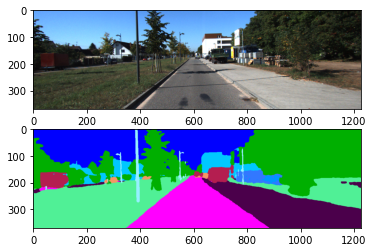

In [4]:
# Generate Random Image
sample_index = np.random.randint(len(kitti_dataset))
sample_img = kitti_dataset.get_cam2(sample_index)

# Generate Predictions
with torch.no_grad():
    img_tensor = img_transform(sample_img)
    pred = net(img_tensor.unsqueeze(0).cuda())
    pred = pred.cpu().numpy().squeeze()
    pred = np.argmax(pred, axis=0)

colored_pred = kitti_colorize(city2kitti_translate(pred))

# Draw the images
fig, axs = plt.subplots(2)
axs[0].imshow(sample_img)
axs[1].imshow(colored_pred)

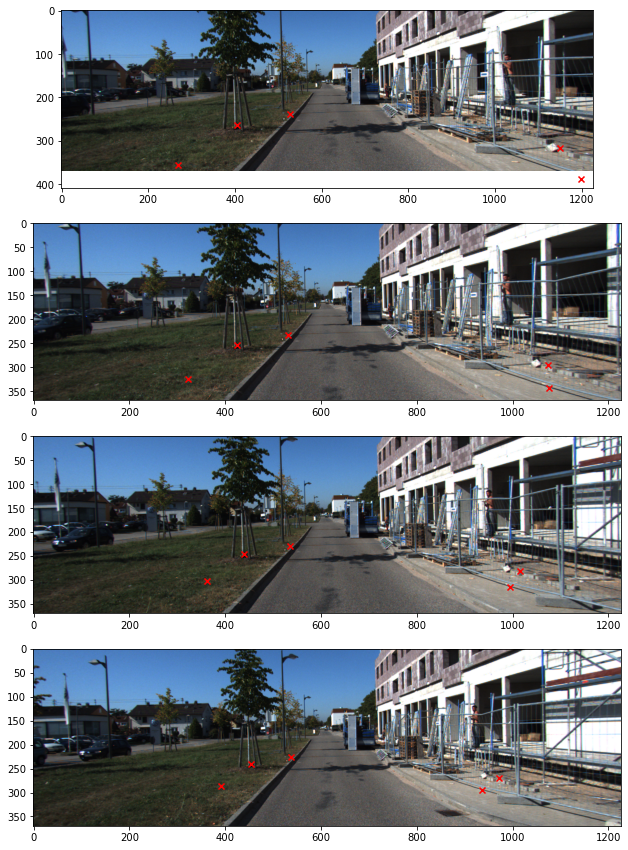

In [5]:
# Project Point Cloud to Images
from project import points2image_project, frame2frame_project

num_prev = 4

sample_index = np.random.randint(len(kitti_dataset))
sample_velo = kitti_dataset.get_velo(sample_index)

mapping_dict = {
    tuple(v[:3]) : [] for v in sample_velo
}

cur_xyz, cur_xy = points2image_project(sample_velo, kitti_dataset.calib)
for i in range(cur_xyz.shape[1]):
    key = (
        cur_xyz[0][i],
        cur_xyz[1][i],
        cur_xyz[2][i]
    )
    mapping = (
        np.int32(cur_xy[0][i]),
        np.int32(cur_xy[1][i])
    )
    mapping_dict[key].append(mapping)

for i in range(1, num_prev):
    pre_xyz = frame2frame_project(
        sample_velo,
        kitti_dataset.poses[sample_index],
        kitti_dataset.poses[sample_index - i],
        kitti_dataset.calib.T_cam0_velo
    )

    points_dict = {
        tuple(pre[:3]): tuple(cur[:3])
        for pre, cur in zip(pre_xyz, sample_velo)
    }

    pre_xyz, pre_xy = points2image_project(pre_xyz, kitti_dataset.calib)
    for i in range(pre_xyz.shape[1]):
        key = points_dict[(
            pre_xyz[0][i],
            pre_xyz[1][i],
            pre_xyz[2][i]
        )]
        mapping = (
            np.int32(pre_xy[0][i]),
            np.int32(pre_xy[1][i])
        )
        mapping_dict[key].append(mapping)

final_result = [
    value 
    for value in mapping_dict.values()
    if len(value) == num_prev
]

projections = [ final_result[i] for i in np.random.randint(0, len(final_result), (5, ))]

fig, axes = plt.subplots(num_prev, figsize=(25, 15))
for i in range(num_prev):
    axis = axes[i]
    axis.imshow(kitti_dataset.get_cam2(sample_index - i))
    for s in range(5):
        axis.scatter(projections[s][i][0], projections[s][i][1], marker='x', color='red')





In [6]:
velo_label_path = f'../kitti-dataset/sequences/{seq}/labels'

labels = []
for l in sorted(os.listdir(velo_label_path)):
    label = np.fromfile(os.path.join(velo_label_path, l), dtype=np.int32)
    labels.append(label)

print(len(labels))

1101


In [ ]:
def predict_sequence_on_label(net, kitti, num_prev):
    predictions = []
    image_labels = deque(maxlen=num_prev)
    poses = deque(maxlen=num_prev)

    for idx, point in enumerate(kitti.velo):
        current_image = kitti.get_cam2(idx)
        with torch.no_grad():
            img_tensor = img_transform(current_image)
            pred = net(img_tensor.unsqueeze(0).cuda())
            pred = pred.cpu().numpy().squeeze()
            current_image_label= city2kitti_translate(np.argmax(pred, axis=0))
        
        current_pose = kitti.poses[idx]

        predictions.append(predit_on_label(
            point,
            current_image_label,
            current_pose,
            image_labels,
            poses,
            kitti.calib
        ))

        image_labels.append(current_image_label)
        poses.append(current_pose)
    
    return predictions

In [ ]:
num_prev = 3

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

In [ ]:
num_prev = 5

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

In [ ]:
num_prev = 7

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

In [ ]:
num_prev = 9

start_time = time.time()
predictions = predict_sequence_on_label(net, kitti_dataset, num_prev)
end_time = time.time()

print('Inference takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

start_time = time.time()
mean_ap = evaluate_sequence(predictions, labels)
end_time = time.time()

print(f'Mean Average Precision: {mean_ap:2f}')
print('Evaluation takes %4.2f seconds, which is %4.2f seconds per image' %
      (end_time - start_time, (end_time - start_time)/len(kitti_dataset)))

## Segmentation based on Image Features

### Create Dataset

The last layer in the DeepWV3Plus network is deleted in order to extract the
image feature instead of the final labels.
In order to train network based on the features from the image, we create a dataset
using the adapted network. In this dataset, the input value is 256 features and 
the label is the ground truth value of that point in semanticKitti.
The features are averaged from previous 3 frames.  

In [10]:
feature_dataset_path = r"../feature-dataset"

generate_dataset(
    ['01', '02', '03', '04', '05', '06'], 
    feature_dataset_path, 
    kitti_dataset_path, 
    snapshot,
    dataset_size=100000
)

Net Built
Net restored
20000 / 100000 data added.
40000 / 100000 data added.
60000 / 100000 data added.
80000 / 100000 data added.
100000 / 100000 data added.
115026 / 100000 data added.


In [11]:
feature_dataset_path = r"../feature-dataset"
loss_function = nn.CrossEntropyLoss()

Epoch 0 : 0.47197902476098036
Epoch 20 : 0.10249600445518106
Epoch 40 : 0.07412267637307506
Epoch 60 : 0.05840368762491136
Epoch 80 : 0.04889929699281581
Epoch 100 : 0.0435654385115338
Epoch 120 : 0.03928338260223076
Epoch 140 : 0.03534719713749126
Epoch 160 : 0.03594312935727529
Epoch 180 : 0.03013737776456038


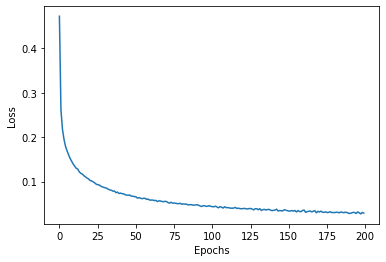

In [15]:
feature_dataset = FeatureDB(feature_dataset_path)
feature_net = FeatureNet().cuda()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

batch_size = 128
learning_rate = 0.001
epochs = 200

data_loader = DataLoader(
    feature_dataset,
    batch_size=batch_size,
    shuffle=True
)
optimizer = optim.Adam(feature_net.parameters(), lr=learning_rate)

losses = []

for e in range(epochs):
    epoch_loss = 0.0

    for _, data in enumerate(data_loader):
        input, target = data
        input, target = input.cuda(), target.cuda()

        optimizer.zero_grad()
        pred = feature_net(input)

        loss = loss_function(pred, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(data_loader)
    losses.append(epoch_loss)

    if (e % 20 == 0):    
        print('Epoch ' + str(e) + ' : ' + str(epoch_loss))


plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses)

In [16]:
torch.save(feature_net.state_dict(), './feature_net.pth')

In [4]:
from predict import predict_on_feature

kitti_dataset = pykitti.odometry(kitti_dataset_path, sequence='09')
all_predictions = predict_on_feature(kitti_dataset, "./kitti_best.pth")

Image Net Built
Image Net restored
Feature Net restored
finish 0
finish 1
finish 2
finish 3
finish 4
finish 5
finish 6
finish 7
finish 8
finish 9
finish 10
finish 11
finish 12
finish 13
finish 14
finish 15
finish 16
finish 17
finish 18
finish 19
finish 20
finish 21
finish 22
finish 23
finish 24
finish 25
finish 26
finish 27
finish 28
finish 29
finish 30
finish 31
finish 32
finish 33
finish 34
finish 35
finish 36
finish 37
finish 38
finish 39
finish 40
finish 41
finish 42
finish 43
finish 44
finish 45
finish 46
finish 47
finish 48
finish 49
finish 50
finish 51
finish 52
finish 53
finish 54
finish 55
finish 56
finish 57
finish 58
finish 59
finish 60
finish 61
finish 62
finish 63
finish 64
finish 65
finish 66
finish 67
finish 68
finish 69
finish 70
finish 71
finish 72
finish 73
finish 74
finish 75
finish 76
finish 77
finish 78
finish 79
finish 80
finish 81
finish 82
finish 83
finish 84
finish 85
finish 86
finish 87
finish 88
finish 89
finish 90
finish 91
finish 92
finish 93
finish 94
fini

1. Title:3D Point Cloud Semantic Segmentation from Multi-View 2D Images.  
   1. Learning 3D Point Cloud Segmentation by Aggregating 2D Image Semantics
2. PointNet PointNet++
3. Test set not has pose
4. projection function 